# Comprehensive Clustering Methods Comparison
This notebook compares K-means, GMM, Agglomerative, and OPTICS clustering on PCA-transformed EEG data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import clustering functions
from functions.k_means_clustering import kmeans_multiple_runs, select_optimal_k
from functions.gmm_clustering import gmm_clustering, select_optimal_n_gmm
from functions.agglomerative_clustering import agglomerative_clustering, select_optimal_n_agglomerative
from functions.optics_clustering import optics_clustering, tune_optics_min_samples, tune_optics_xi

# Import preprocessing
from functions.feature_preprocessing import load_pca_data

# Import metrics
from metrics.internal_metrics import (
    compute_silhouette_score,
    compute_davies_bouldin_score,
    compute_calinski_harabasz_score
)

In [2]:
pca_data, pca_features, loadings = load_pca_data()
print(f"Data shape: {pca_features.shape}")
print(f"Number of subjects: {pca_features.shape[0]}")
print(f"Number of PCA components: {pca_features.shape[1]}")

Data shape: (600, 16)
Number of subjects: 600
Number of PCA components: 16


In [3]:
k_range = list(range(2, 11))

## 1. K-Means Clustering

In [4]:
print("Finding optimal k for K-means...")

# select optimal k using elbow method
optimal_k_kmeans, kmeans_results = select_optimal_k(
    pca_features, 
    k_range=k_range, 
    metric='elbow',
    n_runs=10,
    random_state=42
)
print(f"Optimal k (K-means): {optimal_k_kmeans}")

# Get best result
kmeans_best = kmeans_results[optimal_k_kmeans]
kmeans_labels = kmeans_best['assignments']

# Compute metrics
kmeans_metrics = {
    'silhouette': compute_silhouette_score(pca_features, kmeans_labels),
    'davies_bouldin': compute_davies_bouldin_score(pca_features, kmeans_labels),
    'calinski_harabasz': compute_calinski_harabasz_score(pca_features, kmeans_labels),
}

print(f"\nK-means Metrics (k={optimal_k_kmeans}):")
print(f"  Silhouette Score: {kmeans_metrics['silhouette']:.4f}")
print(f"  Davies-Bouldin Index: {kmeans_metrics['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz Score: {kmeans_metrics['calinski_harabasz']:.2f}")

Finding optimal k for K-means...
Optimal k (K-means): 6

K-means Metrics (k=6):
  Silhouette Score: 0.1143
  Davies-Bouldin Index: 2.0100
  Calinski-Harabasz Score: 68.45


## 2. Gaussian Mixture Model (GMM)

print("Finding optimal number of components for GMM...")

### compare covariance types

# select optimal n of clusters using bic
optimal_k_gmm, gmm_results = select_optimal_n_gmm(
    pca_features,
    n_range=k_range,
    metric='bic',
    covariance_type='full',
    random_state=42,
    verbose=False
)
print(f"Optimal k (GMM): {optimal_k_gmm}")

# Get best result
gmm_best = gmm_results[optimal_k_gmm]
gmm_labels = gmm_best['labels']

# Compute metrics
gmm_metrics = {
    'silhouette': compute_silhouette_score(pca_features, gmm_labels),
    'davies_bouldin': compute_davies_bouldin_score(pca_features, gmm_labels),
    'calinski_harabasz': compute_calinski_harabasz_score(pca_features, gmm_labels),
    'bic': gmm_best['bic'],
    'aic': gmm_best['aic']
}

print(f"\nGMM Metrics (k={optimal_k_gmm}):")
print(f"  Silhouette Score: {gmm_metrics['silhouette']:.4f}")
print(f"  Davies-Bouldin Index: {gmm_metrics['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz Score: {gmm_metrics['calinski_harabasz']:.2f}")
print(f"  BIC: {gmm_metrics['bic']:.2f}")
print(f"  AIC: {gmm_metrics['aic']:.2f}")

In [5]:
print("Selecting the single best GMM model: k by BIC, covariance by Silhouette...\n")

covariance_types = ['full', 'tied', 'diag', 'spherical']
all_results = {}

best_global_sil = -np.inf
best_global_config = None

for cov in covariance_types:

    optimal_k_gmm, gmm_results = select_optimal_n_gmm(
        pca_features,
        n_range=k_range,
        metric='bic',              # still select k using BIC
        covariance_type=cov,
        random_state=42,
        verbose=False
    )

    best_model = gmm_results[optimal_k_gmm]
    labels = best_model['labels']

    # Compute silhouette for best model at optimal k
    sil = compute_silhouette_score(pca_features, labels)

    # Save results
    all_results[cov] = {
        'k': optimal_k_gmm,
        'model': best_model,
        'silhouette': sil,
        'bic': best_model['bic'],
        'aic': best_model['aic']
    }

    if sil > best_global_sil:
        best_global_sil = sil
        best_global_config = (cov, optimal_k_gmm, best_model)

# FINAL SELECTION: best covariance type by silhouette
best_cov, best_k_gmm, best_gmm_model = best_global_config
gmm_labels = best_gmm_model['labels']

print("\nBest Overall GMM Model (k by BIC, covariance by Silhouette):")
print(f" Covariance type: {best_cov}")
print(f" Optimal k:        {best_k_gmm}")
print(f" Silhouette:       {best_global_sil:.4f}\n")

# Compute additional metrics
gmm_metrics = {
    'silhouette': best_global_sil,
    'davies_bouldin': compute_davies_bouldin_score(pca_features, gmm_labels),
    'calinski_harabasz': compute_calinski_harabasz_score(pca_features, gmm_labels),
    'bic': best_gmm_model['bic'],
    'aic': best_gmm_model['aic']
}

print(f"\nGMM Metrics (k={best_k_gmm}):")
print(f"  Silhouette Score:     {gmm_metrics['silhouette']:.4f}")
print(f"  Davies-Bouldin Index: {gmm_metrics['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz:    {gmm_metrics['calinski_harabasz']:.2f}")
print(f"  BIC:                  {gmm_metrics['bic']:.2f}")
print(f"  AIC:                  {gmm_metrics['aic']:.2f}")


Selecting the single best GMM model: k by BIC, covariance by Silhouette...


Best Overall GMM Model (k by BIC, covariance by Silhouette):
 Covariance type: full
 Optimal k:        3
 Silhouette:       0.1474


GMM Metrics (k=3):
  Silhouette Score:     0.1474
  Davies-Bouldin Index: 2.1986
  Calinski-Harabasz:    66.42
  BIC:                  43625.42
  AIC:                  41611.63


## 3. Agglomerative Clustering

print("Finding optimal k for Agglomerative clustering...")

# compare linkage methods

# select optimal n of clusters using silhouette score
optimal_k_agg, agg_results = select_optimal_n_agglomerative(
    pca_features,
    n_range=k_range,
    metric='euclidean',
    linkage_method='ward',
    selection_metric='silhouette',
    verbose=False
)
print(f"Optimal k (Agglomerative): {optimal_k_agg}")

# Get best result
agg_best = agg_results[optimal_k_agg]
agg_labels = agg_best['labels']

# Compute metrics
agg_metrics = {
    'silhouette': compute_silhouette_score(pca_features, agg_labels),
    'davies_bouldin': compute_davies_bouldin_score(pca_features, agg_labels),
    'calinski_harabasz': compute_calinski_harabasz_score(pca_features, agg_labels),
}

print(f"\nAgglomerative Metrics (k={optimal_k_agg}):")
print(f"  Silhouette Score: {agg_metrics['silhouette']:.4f}")
print(f"  Davies-Bouldin Index: {agg_metrics['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz Score: {agg_metrics['calinski_harabasz']:.2f}")

In [6]:
print("Selecting the single best Agglomerative model: k by silhouette, linkage by silhouette...\n")

linkage_methods = ['complete', 'average', 'single', 'ward']

all_results = {}
best_global_sil = -np.inf
best_global_config = None

for linkage in linkage_methods:

    # select optimal k for this linkage using silhouette 
    optimal_k_agg, agg_results = select_optimal_n_agglomerative(
        pca_features,
        n_range=k_range,
        metric='euclidean',
        linkage_method=linkage,
        selection_metric='silhouette',
        verbose=False
    )

    best_model = agg_results[optimal_k_agg]
    labels = best_model['labels']

    sil = compute_silhouette_score(pca_features, labels)

    all_results[linkage] = {
        'k': optimal_k_agg,
        'model': best_model,
        'silhouette': sil
    }

    if sil > best_global_sil:
        best_global_sil = sil
        best_global_config = (linkage, optimal_k_agg, best_model)

#FINAL SELECTION: best linkage method + optimal k

best_linkage, best_k_agg, best_agg_model = best_global_config
agg_labels = best_agg_model['labels']

print("\nBest Overall Agglomerative Model (linkage by silhouette):")
print(f" Linkage method:  {best_linkage}")
print(f" Optimal k:       {best_k_agg}")
print(f" Silhouette:      {best_global_sil:.4f}\n")

# Compute additional metrics
agg_metrics = {
    'silhouette': best_global_sil,
    'davies_bouldin': compute_davies_bouldin_score(pca_features, agg_labels),
    'calinski_harabasz': compute_calinski_harabasz_score(pca_features, agg_labels),
}

print(f"\nAgglomerative Metrics (k={best_k_agg}):")
print(f"  Silhouette Score:     {agg_metrics['silhouette']:.4f}")
print(f"  Davies-Bouldin Index: {agg_metrics['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz:    {agg_metrics['calinski_harabasz']:.2f}")


Selecting the single best Agglomerative model: k by silhouette, linkage by silhouette...


Best Overall Agglomerative Model (linkage by silhouette):
 Linkage method:  complete
 Optimal k:       2
 Silhouette:      0.7040


Agglomerative Metrics (k=2):
  Silhouette Score:     0.7040
  Davies-Bouldin Index: 0.2107
  Calinski-Harabasz:    20.45


## 4. OPTICS Clustering

min_samples_range = [5, 10, 15, 20, 25]

# tune xi

# select optimal n of clusters using silhouette score
optimal_min_samples, optics_results = tune_optics_min_samples(
    pca_features,
    min_samples_range=min_samples_range,
    metric='euclidean',
    cluster_method='xi',
    xi=0.01,
    verbose=False
)
print(f"Optimal min_samples (OPTICS): {optimal_min_samples}")

# Get best result
optics_best = optics_results[optimal_min_samples]
optics_labels = optics_best['labels']
optics_n_clusters = optics_best['n_clusters']

print(f"OPTICS found {optics_n_clusters} clusters")

# Compute metrics (excluding noise points)
if optics_n_clusters > 1:
    non_noise_mask = optics_labels != -1
    n_noise = np.sum(~non_noise_mask)
    print(f"Number of noise points: {n_noise}")
    
    if np.sum(non_noise_mask) > 0:
        filtered_data = pca_features[non_noise_mask]
        filtered_labels = optics_labels[non_noise_mask]
        
        optics_metrics = {
            'silhouette': compute_silhouette_score(filtered_data, filtered_labels),
            'davies_bouldin': compute_davies_bouldin_score(filtered_data, filtered_labels),
            'calinski_harabasz': compute_calinski_harabasz_score(filtered_data, filtered_labels),
            'n_noise': n_noise
        }
        
        print(f"\nOPTICS Metrics (k={optics_n_clusters}, excluding noise):")
        print(f"  Silhouette Score: {optics_metrics['silhouette']:.4f}")
        print(f"  Davies-Bouldin Index: {optics_metrics['davies_bouldin']:.4f}")
        print(f"  Calinski-Harabasz Score: {optics_metrics['calinski_harabasz']:.2f}")
    else:
        print("All points classified as noise!")
        optics_metrics = {'silhouette': -1, 'davies_bouldin': np.inf, 'calinski_harabasz': 0, 'n_noise': n_noise}
else:
    print("OPTICS did not find valid clusters")
    optics_metrics = {'silhouette': -1, 'davies_bouldin': np.inf, 'calinski_harabasz': 0, 'n_noise': len(optics_labels)}

In [7]:
print("Selecting the best OPTICS model: tuning min_samples and xi by Silhouette...\n")

min_samples_range = [2, 3, 5, 7, 10]
xi_range = [0.001, 0.005, 0.01, 0.02]

all_results = {}
best_global_sil = -np.inf
best_global_config = None

# Iterate over min_samples
for min_samples in min_samples_range:

    # Tune xi for this min_samples
    best_xi, xi_results = tune_optics_xi(
        pca_features,
        xi_range=xi_range,
        min_samples=min_samples,
        metric='euclidean',
        verbose=False
    )

    # Get the best xi result
    best_result = xi_results[best_xi]
    labels = best_result['labels']
    n_clusters = best_result['n_clusters']

    # Filter out noise points for metric computation
    non_noise_mask = labels != -1
    filtered_data = pca_features[non_noise_mask] if np.sum(non_noise_mask) > 0 else np.array([]) 
    filtered_labels = labels[non_noise_mask] if np.sum(non_noise_mask) > 0 else np.array([])

    # Compute silhouette if valid clusters exist
    sil = compute_silhouette_score(filtered_data, filtered_labels) if len(filtered_labels) > 0 else -1

    # Save results
    all_results[(min_samples, best_xi)] = {
        'labels': labels,
        'n_clusters': n_clusters,
        'silhouette': sil,
        'n_noise': np.sum(~non_noise_mask)
    }

    # Update global best
    if sil > best_global_sil:
        best_global_sil = sil
        best_global_config = (min_samples, best_xi, best_result)


# FINAL SELECTION
best_min_samples, best_xi, best_optics_model = best_global_config
optics_labels = best_optics_model['labels']
optics_n_clusters = best_optics_model['n_clusters']
non_noise_mask = optics_labels != -1
n_noise = np.sum(~non_noise_mask)
filtered_data = pca_features[non_noise_mask]
filtered_labels = optics_labels[non_noise_mask]

print(f"Best OPTICS Model:")
print(f" min_samples:    {best_min_samples}")
print(f" xi:             {best_xi}")
print(f" Clusters found: {optics_n_clusters}")
print(f" Noise points:   {n_noise}")

# Compute metrics excluding noise
if optics_n_clusters > 1 and len(filtered_labels) > 0:
    optics_metrics = {
        'silhouette': compute_silhouette_score(filtered_data, filtered_labels),
        'davies_bouldin': compute_davies_bouldin_score(filtered_data, filtered_labels),
        'calinski_harabasz': compute_calinski_harabasz_score(filtered_data, filtered_labels),
        'n_noise': n_noise
    }

    print(f"\nOPTICS Metrics (k={optics_n_clusters}, excluding noise):")
    print(f"  Silhouette Score:     {optics_metrics['silhouette']:.4f}")
    print(f"  Davies-Bouldin Index: {optics_metrics['davies_bouldin']:.4f}")
    print(f"  Calinski-Harabasz:    {optics_metrics['calinski_harabasz']:.2f}")
else:
    print("OPTICS did not find valid clusters or all points classified as noise")
    optics_metrics = {'silhouette': -1, 'davies_bouldin': np.inf, 'calinski_harabasz': 0, 'n_noise': n_noise}

Selecting the best OPTICS model: tuning min_samples and xi by Silhouette...

Best OPTICS Model:
 min_samples:    10
 xi:             0.01
 Clusters found: 3
 Noise points:   563

OPTICS Metrics (k=3, excluding noise):
  Silhouette Score:     0.2598
  Davies-Bouldin Index: 1.3519
  Calinski-Harabasz:    22.32


OPTICS is not finding any robust density-based structure in the data, so almost all points remain noise.

## Summary for visualization

In [8]:
# Create summary dataframe
summary_data = {
    'Algorithm': ['K-means', 'GMM', 'Agglomerative', 'OPTICS'],
    'Optimal k': [optimal_k_kmeans, best_k_gmm, best_k_agg, optics_n_clusters],
    'Silhouette': [
        kmeans_metrics['silhouette'],
        gmm_metrics['silhouette'],
        agg_metrics['silhouette'],
        optics_metrics['silhouette']
    ],
    'Davies-Bouldin': [
        kmeans_metrics['davies_bouldin'],
        gmm_metrics['davies_bouldin'],
        agg_metrics['davies_bouldin'],
        optics_metrics['davies_bouldin']
    ],
    'Calinski-Harabasz': [
        kmeans_metrics['calinski_harabasz'],
        gmm_metrics['calinski_harabasz'],
        agg_metrics['calinski_harabasz'],
        optics_metrics['calinski_harabasz']
    ]
}

summary_df = pd.DataFrame(summary_data)

## Visualization

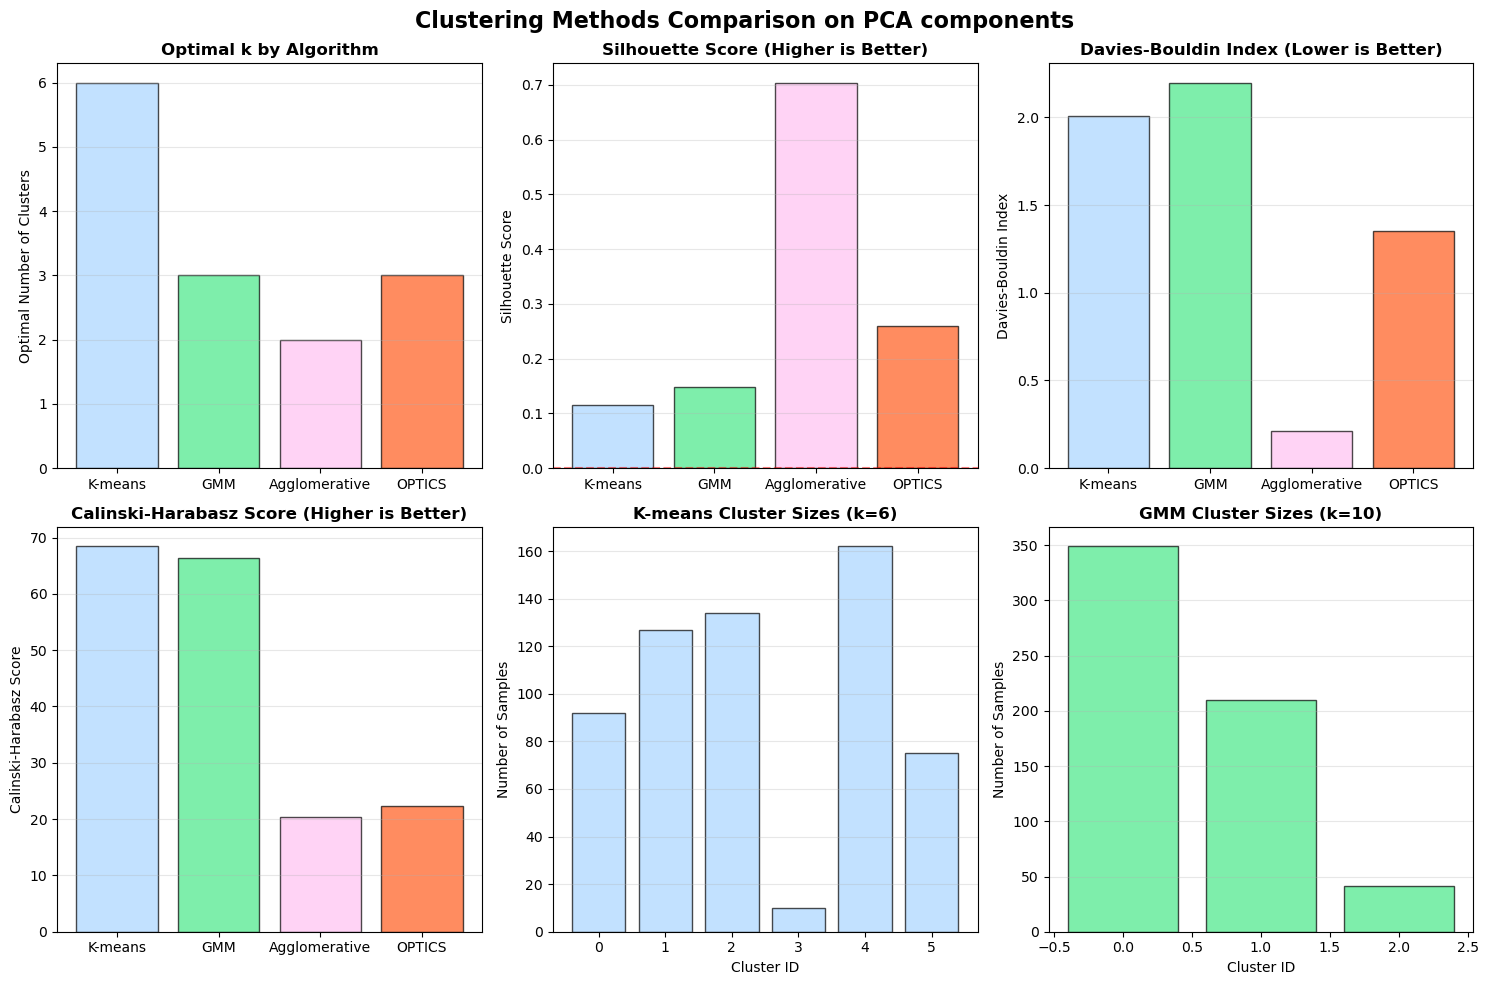


Analysis complete!


In [9]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Clustering Methods Comparison on PCA components', fontsize=16, fontweight='bold')

algorithms = ['K-means', 'GMM', 'Agglomerative', 'OPTICS']
colors = ["#A8D5FF", "#48E888", "#FFC1F2", "#FF5C1C"]

# Plot 1: Optimal k comparison
ax1 = axes[0, 0]
optimal_ks = [optimal_k_kmeans, best_k_gmm, best_k_agg, optics_n_clusters]
ax1.bar(algorithms, optimal_ks, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Optimal Number of Clusters', fontsize=10)
ax1.set_title('Optimal k by Algorithm', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Silhouette Score comparison
ax2 = axes[0, 1]
silhouette_scores = summary_df['Silhouette'].tolist()
ax2.bar(algorithms, silhouette_scores, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Silhouette Score', fontsize=10)
ax2.set_title('Silhouette Score (Higher is Better)', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Davies-Bouldin Index comparison
ax3 = axes[0, 2]
db_scores = summary_df['Davies-Bouldin'].tolist()
ax3.bar(algorithms, db_scores, color=colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Davies-Bouldin Index', fontsize=10)
ax3.set_title('Davies-Bouldin Index (Lower is Better)', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Calinski-Harabasz Score comparison
ax4 = axes[1, 0]
ch_scores = summary_df['Calinski-Harabasz'].tolist()
ax4.bar(algorithms, ch_scores, color=colors, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Calinski-Harabasz Score', fontsize=10)
ax4.set_title('Calinski-Harabasz Score (Higher is Better)', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Plot 5: Cluster size distribution for K-means
ax5 = axes[1, 1]
unique_labels, counts = np.unique(kmeans_labels, return_counts=True)
ax5.bar(unique_labels, counts, color="#A8D5FF", alpha=0.7, edgecolor='black')
ax5.set_xlabel('Cluster ID', fontsize=10)
ax5.set_ylabel('Number of Samples', fontsize=10)
ax5.set_title(f'K-means Cluster Sizes (k={optimal_k_kmeans})', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# Plot 6: Cluster size distribution for GMM
ax6 = axes[1, 2]
unique_labels, counts = np.unique(gmm_labels, return_counts=True)
ax6.bar(unique_labels, counts, color='#48E888', alpha=0.7, edgecolor='black')
ax6.set_xlabel('Cluster ID', fontsize=10)
ax6.set_ylabel('Number of Samples', fontsize=10)
ax6.set_title(f'GMM Cluster Sizes (k={optimal_k_gmm})', fontsize=12, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAnalysis complete!")

In [10]:
# we should define other ways to compare clustering methods, 
# rn we are compating silouhette, davies_bouldin and calinski_harabasz scores

# we could use the score index: Calculates the ratio of between-cluster variation to within-cluster variance. 
# Higher values suggest more distinct groups.

# analyze noise points in OPTICS -> too high optics is not performing well

# compute stability for top contenders

# inspect per cluster metrics